# Analyzing Character Archetypes in TV Shows and Movies

This project involves fine-tuning a pre-trained language model to classify character descriptions into archetypes such as "hero," "sidekick," "mentor," and "villain." Using Hugging Face's Transformers and a custom dataset, the model is trained to predict the archetype of a character based on a brief description. The project showcases text classification using NLP and can be deployed for users to classify new character descriptions automatically.

### Prototype

In [10]:
from transformers import pipeline 

In [28]:
archetypes = ["Warrior", "Child", "Orphan", "Creator", "Caregiver", "Mentor", "Joker", "Magician", "Ruler", "Rebel", "Lover", "Seducer"]

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def prototype_classify_character(character_description):
    result = classifier(character_description, candidate_labels=archetypes)
    return result['labels'][0]  # Return the highest scoring archetype

In [29]:
# Now try on an example
character_description =\
"""
Samwise Gamgee from The Lord of the Rings is a loyal, steadfast companion to Frodo Baggins. 
He begins as a humble gardener but proves to be one of the most courageous and selfless characters in the story. 
Despite being seemingly ordinary, Sam consistently demonstrates extraordinary bravery, especially when supporting 
Frodo on their perilous journey to destroy the One Ring. His deep sense of duty, unwavering friendship, and determination 
keep him by Frodo’s side, even in the darkest moments, making him a true hero in his own right, despite never seeking fame 
or glory.
"""

In [30]:
archetype = prototype_classify_character(character_description)
print(f"The character's archetype is: {archetype}")

The character's archetype is: Caregiver


### Load dataset

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 

In [32]:
arch_data = pd.read_csv("archetype_data.csv")

In [33]:
arch_data.head()

,description,archetype
0,A decorated general who leads an army into bat...,warrior
1,A skilled mercenary who takes on dangerous mis...,warrior
2,A young knight eager to prove themselves on th...,warrior
3,A seasoned veteran who commands a group of sol...,warrior
4,A fearless bounty hunter with a reputation for...,warrior


In [34]:
arch_data['description'][0]

'A decorated general who leads an army into battle, renowned for their tactical genius and unshakeable confidence.'

<Axes: xlabel='archetype'>

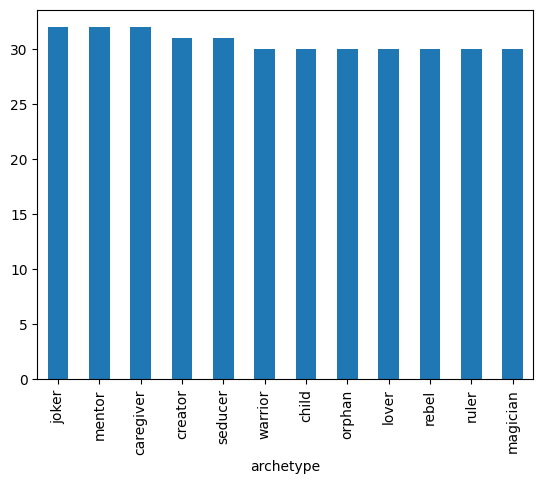

In [35]:
arch_data['archetype'].value_counts().plot(kind="bar")

In [49]:
arch_data['arch_int'] = LabelEncoder().fit_transform(arch_data['archetype'])

<Axes: xlabel='arch_int'>

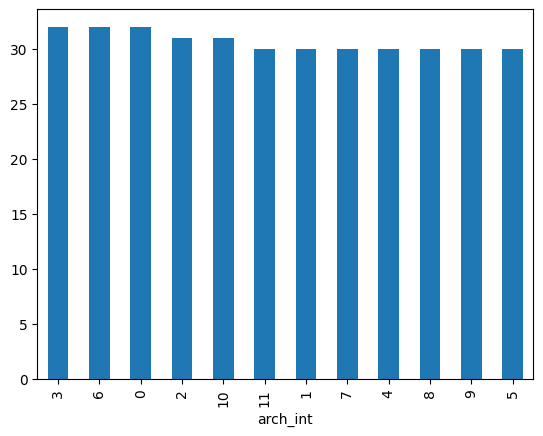

In [66]:
arch_data['arch_int'].value_counts().plot(kind="bar")

In [55]:
train_split, test_split = train_test_split(arch_data, train_size = 0.8)

train_df = pd.DataFrame({
    "label": train_split.arch_int.values,
    "text": train_split.description.values
})
train_df = datasets.Dataset.from_dict(train_df)

test_df = pd.DataFrame({
    "label": test_split.arch_int.values,
    "text": test_split.description.values
})
test_df = datasets.Dataset.from_dict(test_df)

dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

### Preprocess data

In [36]:
from transformers import AutoTokenizer

In [37]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [57]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [61]:
tokenized_data = dataset_dict.map(preprocess_function, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 8144.49 examples/s]


### Train model

In [69]:
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [63]:
accuracy = evaluate.load("accuracy")

In [65]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [67]:
id2label = {
    0: "Caregiver",
    1: "Child",
    2: "Creator",
    3: "Joker",
    4: "Lover",
    5: "Magician",
    6: "Mentor",
    7: "Orphan",
    8: "Rebel",
    9: "Ruler",
    10: "Seducer",
    11: "Warrior"
}

In [68]:
label2id = {
    "Caregiver": 0,
    "Child": 1,
    "Creator": 2,
    "Joker": 3,
    "Lover": 4,
    "Magician": 5,
    "Mentor": 6,
    "Orphan": 7,
    "Rebel": 8,
    "Ruler": 9,
    "Seducer": 10,
    "Warrior": 11
}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=12, id2label=id2label, label2id=label2id
)